<a href="https://colab.research.google.com/github/qmyhd/UVA-ArchNet/blob/main/qmy6cv_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

# Assignment 2: Designing an Architecture for Recognizing UVA Historical Landmarks
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this assignment, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 100 points for this assignment if you successfully transfer at least 3 existing architectures, plus 10 bonus points if your classifier performance exceeds 94% accuracy.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Canvas with the following format: yourcomputingID_assignment_2.ipynb

Best of luck, and have fun!

## TA's notes
Requirements:
- You must be able to implement a complete training/validation loop with a final test. The basic logic is similar to the FashionMNIST in previous tutorials.
- You must use 3 models. You could create/train all models from scratch or you can use transfer learning (for example, torchvision.models.resnet18) for one, two, or all of them. You may find CNN-specific architectures (e.g., LeNet, AlexNet, ResNet variants, GoogLeNet, VGG, etc) will be helpful. The most widely used CNN architectures include VGG-16 and ResNet-FPN-X101 (but they may be too big for Google Colab GPUs, so try small variants if that's the case). You could also try state-of-the-art Vision Transformers (ViT) but it's technically not a CNN so the rest of your models must both be CNN. ViTs might also be too big for the Google Colab GPUs. The above-mentioned architectures all have pretrained versions in [torchvision](https://pytorch.org/vision/stable/models.html).
- You can use the Sequential model creation instead of the class API, but that can make adding/changing various modules more difficult.
- Please split your own validation set. We've done this in previous tutorials also.
- Please do NOT change the random `SEED` or the test dataset/dataloader so I can verify your performance.
- Please also plot your training and loss curves. This way you and I will both understand the learning process and identify any problem.
- Please make your 3 models sufficiently different. For example, it's not enough to add one layer and call that a different model.

# Load Packages

In [2]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import torch


# Random Seed for Reproduction

In [3]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in a Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [4]:
# Download dataset from FirebaseStorage
!curl -L "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7" -o "dataset.zip"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  378M  100  378M    0     0   142M      0  0:00:02  0:00:02 --:--:--  142M


In [5]:
# Extract content
!unzip -q "dataset.zip"

In [6]:
from sklearn.datasets import load_files

data_dir = "dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150;
img_width = 150;


In [7]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder


TEST_RATIO = 0.2
BATCH_SIZE = 32

# Download and load the training data
dataset_all = ImageFolder(
    data_dir,
    transform=ToTensor(),
)

size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')


size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train, dataset_test = random_split(dataset_all, [size_train, size_test], generator=Generator().manual_seed(SEED))
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}. len(dataset_test)={len(dataset_test)}')

# NOTE that you must not use the test dataset for model selection


Before splitting the full dataset into train and test: len(dataset_all)=14286
After splitting the full dataset into train and test: len(dataset_train)=11429. len(dataset_test)=2857


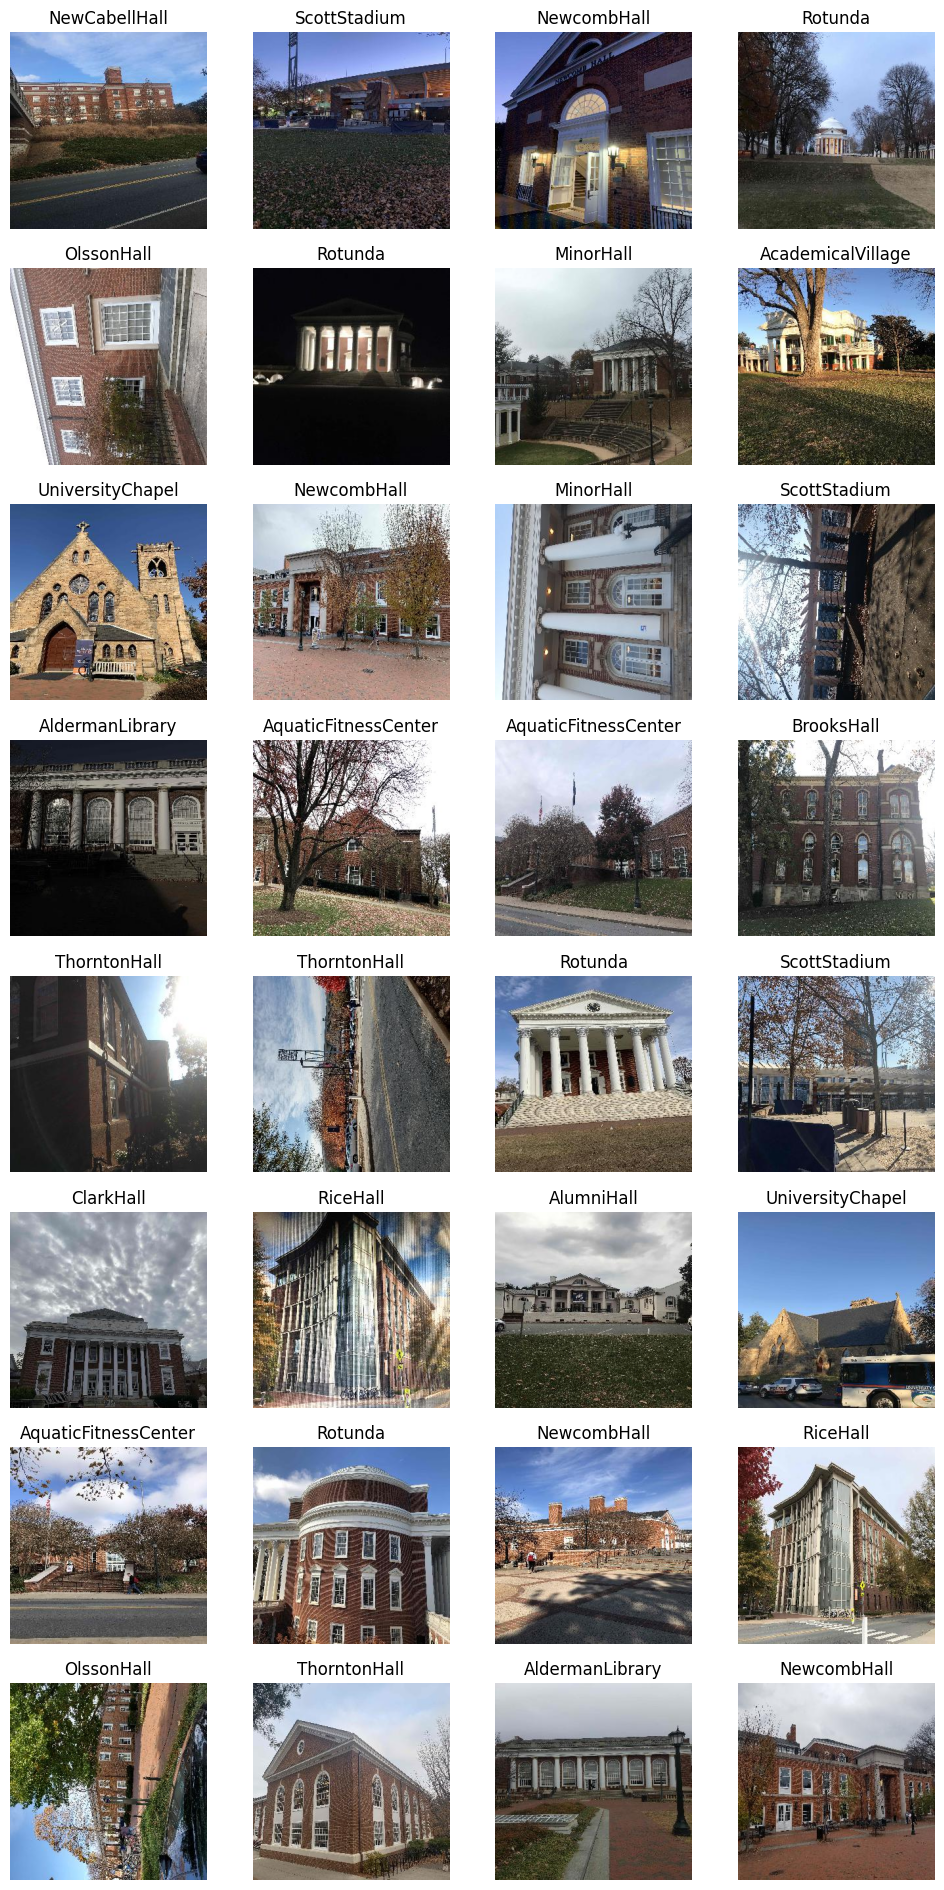

In [8]:
from torchvision.transforms.functional import to_pil_image


# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)

n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

plt.show()

# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks.

Best of luck!

In [9]:
# YOUR CODE STARTS HERE. Feel free to modify anything.
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim

class MyCNN1(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 150×150 -> 75×75 -> 37×37 after two pools, so shape = [batch, 64, 37, 37]
        self.fc1 = nn.Linear(64 * 37 * 37, 128)
        self.dropout = nn.Dropout(0.5) # dropout to reduce overfitting
        self.fc2 = nn.Linear(128, 18)

    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MyCNN1()
print(model)
# test with dummy input
dummy_input = torch.randn(1, 3, 150, 150)
output = model(dummy_input)
print(output.shape)

MyCNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=18, bias=True)
)
torch.Size([1, 18])


In [10]:
# transforms to make the model learn generalizable features rather than memorizing.
transform_cnn1 = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
# Transform for validation/test
val_test_transform_cnn1 = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# CNN1 dataset
dataset_all_cnn1 = ImageFolder(data_dir, transform=transform_cnn1)

# Split into train/test
size_all = len(dataset_all_cnn1)
size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train_cnn1, dataset_test_cnn1 = random_split(
    dataset_all_cnn1,
    [size_train, size_test],
    generator=Generator().manual_seed(SEED)
)

# Split into train/val
val_ratio = 0.2
size_val = int(len(dataset_train_cnn1) * val_ratio)
size_train_only = len(dataset_train_cnn1) - size_val

dataset_train_only_cnn1, dataset_val_cnn1 = random_split(
    dataset_train_cnn1,
    [size_train_only, size_val],
    generator=Generator().manual_seed(SEED)
)

# Update validation transform
dataset_val_cnn1.dataset.transform = val_test_transform_cnn1

# Dataloaders
BATCH_SIZE = 32
train_loader_cnn1 = DataLoader(dataset_train_only_cnn1, batch_size=BATCH_SIZE, shuffle=True)
val_loader_cnn1   = DataLoader(dataset_val_cnn1,        batch_size=BATCH_SIZE, shuffle=False)
test_loader_cnn1  = DataLoader(dataset_test_cnn1,       batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# Function to train and validate the model
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3, patience=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # store history
    history = {'train_loss': [], 'train_acc': [],
               'val_loss': [],   'val_acc': []}

    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training Step
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            # backward
            loss.backward()
            optimizer.step()

            # metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        # Validation Step
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        # Save metrics
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        #summary
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        # Check early stopping criteria
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    return history

# function to evaluate model
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

Epoch [1/20] Train Loss: 2.8294, Train Acc: 0.1044, Val Loss: 2.7743, Val Acc: 0.1164
Epoch [2/20] Train Loss: 2.7306, Train Acc: 0.1424, Val Loss: 2.6982, Val Acc: 0.1786
Epoch [3/20] Train Loss: 2.6619, Train Acc: 0.1702, Val Loss: 2.5711, Val Acc: 0.2053
Epoch [4/20] Train Loss: 2.5863, Train Acc: 0.1978, Val Loss: 2.4765, Val Acc: 0.2512
Epoch [5/20] Train Loss: 2.4940, Train Acc: 0.2259, Val Loss: 2.3987, Val Acc: 0.2713
Epoch [6/20] Train Loss: 2.4268, Train Acc: 0.2411, Val Loss: 2.2882, Val Acc: 0.3155
Epoch [7/20] Train Loss: 2.3583, Train Acc: 0.2656, Val Loss: 2.1978, Val Acc: 0.3304
Epoch [8/20] Train Loss: 2.3110, Train Acc: 0.2760, Val Loss: 2.1436, Val Acc: 0.3440
Epoch [9/20] Train Loss: 2.2607, Train Acc: 0.2969, Val Loss: 2.1370, Val Acc: 0.3484
Epoch [10/20] Train Loss: 2.2122, Train Acc: 0.2980, Val Loss: 2.0591, Val Acc: 0.3847
Epoch [11/20] Train Loss: 2.1698, Train Acc: 0.3186, Val Loss: 2.0330, Val Acc: 0.3869
Epoch [12/20] Train Loss: 2.1157, Train Acc: 0.3364,

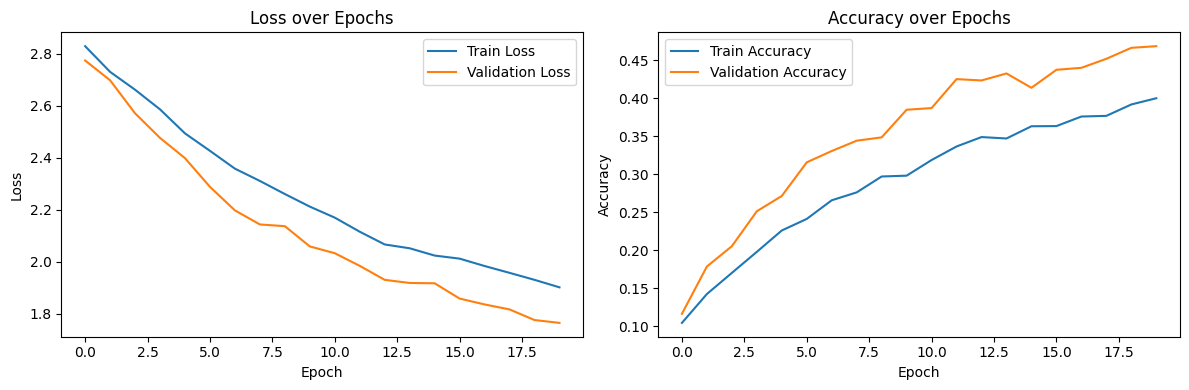

In [12]:
model1 = MyCNN1()
history1 = train_model(model1, train_loader_cnn1, val_loader_cnn1, num_epochs=20, lr=1e-3, patience=3)

# Plot training & validation loss values
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history1['train_loss'], label='Train Loss')
plt.plot(history1['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history1['train_acc'], label='Train Accuracy')
plt.plot(history1['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
evaluate_model(model1, test_loader_cnn1)


Test Accuracy: 0.4757 (47.57%)


In [15]:
from torchvision import models

# convert to PyTorch tensor & 150x150 transformation
efficientnet_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Load dataset with EfficientNet transform
dataset_all_effnet = ImageFolder(data_dir, transform=efficientnet_transform)
# Re-split train/test
size_all = len(dataset_all_effnet)
size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train_effnet, dataset_test_effnet = random_split(
    dataset_all_effnet,
    [size_train, size_test],
    generator=Generator().manual_seed(SEED)
)
# Validation split
val_ratio = 0.2
size_val = int(len(dataset_train_effnet) * val_ratio)
size_train_only = len(dataset_train_effnet) - size_val

dataset_train_only_effnet, dataset_val_effnet = random_split(
    dataset_train_effnet,
    [size_train_only, size_val],
    generator=Generator().manual_seed(SEED)
)

# Dataloaders for CNN2
train_loader_effnet = DataLoader(dataset_train_only_effnet, batch_size=32, shuffle=True)
val_loader_effnet   = DataLoader(dataset_val_effnet,        batch_size=32, shuffle=False)
test_loader_effnet  = DataLoader(dataset_test_effnet,       batch_size=32, shuffle=False)

In [16]:
# CNN2 with EfficientNet-B0
class MyCNN2(Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Freeze feature extractor
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        # Replace classifier
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier[1] = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 18)
        )

    def forward(self, X):
        return self.base_model(X)

# instantiate and test model
model2 = MyCNN2()

dummy_input = torch.randn(1, 3, 150, 150)
output = model2(dummy_input)
print("Dummy output shape:", output.shape)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]


Dummy output shape: torch.Size([1, 18])


Epoch [1/20] Train Loss: 1.8779, Train Acc: 0.4995, Val Loss: 1.3339, Val Acc: 0.6643
Epoch [2/20] Train Loss: 1.3070, Train Acc: 0.6446, Val Loss: 1.1135, Val Acc: 0.7125
Epoch [3/20] Train Loss: 1.1597, Train Acc: 0.6729, Val Loss: 1.0153, Val Acc: 0.7300
Epoch [4/20] Train Loss: 1.0831, Train Acc: 0.6905, Val Loss: 0.9516, Val Acc: 0.7418
Epoch [5/20] Train Loss: 1.0264, Train Acc: 0.7013, Val Loss: 0.9102, Val Acc: 0.7470
Epoch [6/20] Train Loss: 1.0018, Train Acc: 0.7011, Val Loss: 0.8793, Val Acc: 0.7580
Epoch [7/20] Train Loss: 0.9747, Train Acc: 0.7177, Val Loss: 0.8692, Val Acc: 0.7554
Epoch [8/20] Train Loss: 0.9521, Train Acc: 0.7220, Val Loss: 0.8572, Val Acc: 0.7589
Epoch [9/20] Train Loss: 0.9593, Train Acc: 0.7174, Val Loss: 0.8425, Val Acc: 0.7628
Epoch [10/20] Train Loss: 0.9276, Train Acc: 0.7294, Val Loss: 0.8212, Val Acc: 0.7685
Epoch [11/20] Train Loss: 0.9230, Train Acc: 0.7229, Val Loss: 0.8290, Val Acc: 0.7589
Epoch [12/20] Train Loss: 0.9099, Train Acc: 0.7320,

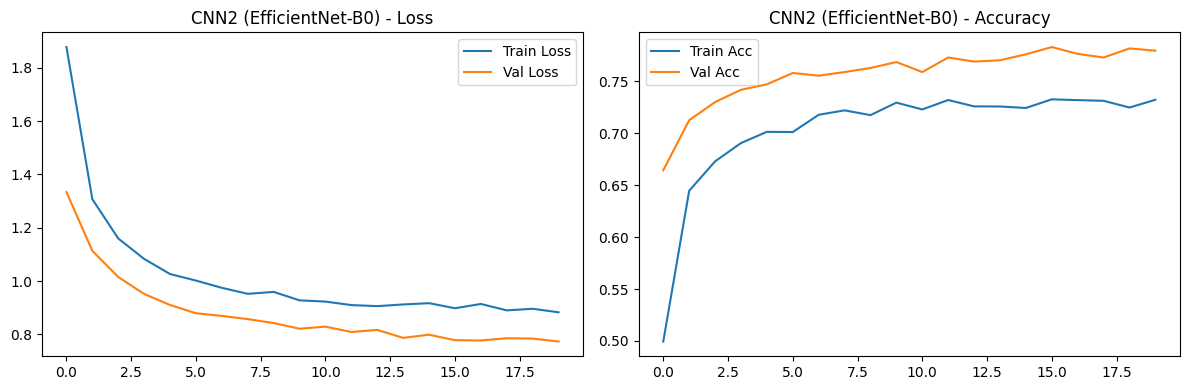

In [17]:
# training model using existing train function
history2 = train_model(model2, train_loader_effnet, val_loader_effnet, num_epochs=20, lr=1e-3, patience=3)

# plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2['train_loss'], label='Train Loss')
plt.plot(history2['val_loss'], label='Val Loss')
plt.title('CNN2 (EfficientNet-B0) - Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2['train_acc'], label='Train Acc')
plt.plot(history2['val_acc'], label='Val Acc')
plt.title('CNN2 (EfficientNet-B0) - Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
evaluate_model(model2, test_loader_effnet)


Test Accuracy: 0.7704 (77.04%)


In [19]:
class MyCNN3(Module):
    def __init__(self):
        super().__init__()
        # Load pretrained ResNet18
        self.base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Unfreeze all layers
        for param in self.base_model.parameters():
            param.requires_grad = True

        # Replace final FC layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 18)  # 18 landmark classes
        )
    def forward(self, X):
        return self.base_model(X)

In [20]:
# ResNet-specific transform
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# Load dataset with ResNet transform
dataset_all_resnet = ImageFolder(data_dir, transform=resnet_transform)
# Split into train and test
size_all = len(dataset_all_resnet)
size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train_resnet, dataset_test_resnet = random_split(
    dataset_all_resnet,
    [size_train, size_test],
    generator=Generator().manual_seed(SEED)
)
# Split training into train and validation
val_ratio = 0.2
size_val = int(len(dataset_train_resnet) * val_ratio)
size_train_only = len(dataset_train_resnet) - size_val

dataset_train_only_resnet, dataset_val_resnet = random_split(
    dataset_train_resnet,
    [size_train_only, size_val],
    generator=Generator().manual_seed(SEED)
)

train_loader_resnet = DataLoader(dataset_train_only_resnet, batch_size=32, shuffle=True)
val_loader_resnet   = DataLoader(dataset_val_resnet,        batch_size=32, shuffle=False)
test_loader_resnet  = DataLoader(dataset_test_resnet,       batch_size=32, shuffle=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


Epoch [1/20] Train Loss: 0.8704, Train Acc: 0.7753, Val Loss: 0.2975, Val Acc: 0.9287
Epoch [2/20] Train Loss: 0.1766, Train Acc: 0.9631, Val Loss: 0.2122, Val Acc: 0.9532
Epoch [3/20] Train Loss: 0.0568, Train Acc: 0.9900, Val Loss: 0.1853, Val Acc: 0.9589
Epoch [4/20] Train Loss: 0.0264, Train Acc: 0.9957, Val Loss: 0.2014, Val Acc: 0.9562
Epoch [5/20] Train Loss: 0.0183, Train Acc: 0.9972, Val Loss: 0.1868, Val Acc: 0.9628
Epoch [6/20] Train Loss: 0.0096, Train Acc: 0.9991, Val Loss: 0.1907, Val Acc: 0.9619
Early stopping triggered after epoch 6


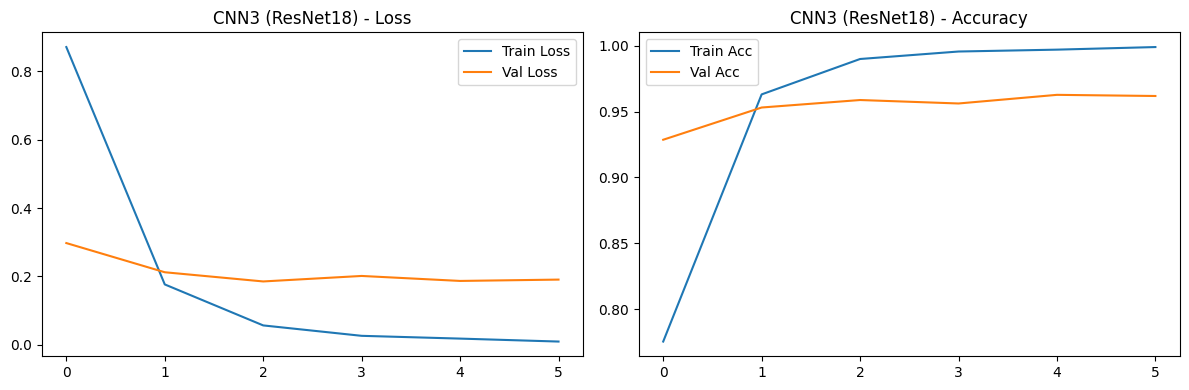

In [21]:
model3 = MyCNN3()
history3 = train_model(model3, train_loader_resnet, val_loader_resnet, num_epochs=20, lr=1e-4, patience=3)

# plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3['train_loss'], label='Train Loss')
plt.plot(history3['val_loss'], label='Val Loss')
plt.title('CNN3 (ResNet18) - Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3['train_acc'], label='Train Acc')
plt.plot(history3['val_acc'], label='Val Acc')
plt.title('CNN3 (ResNet18) - Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
evaluate_model(model3, test_loader_resnet)

Test Accuracy: 0.9590 (95.90%)
